In [1]:
import struct
from datetime import datetime
from IPython.display import Image

In [2]:
with open('net.cap', 'rb') as f:
    data = f.read()

In [3]:
raw = data[:]
pcap_file_header = raw[:24]
raw = raw[24:]

ethernet_packets = []
timestamps = []
while raw:
    packet_header = raw[:16]
    raw = raw[16:]
#     print(list(packet_header))
    tsec = struct.unpack('I', packet_header[:4])[0]
    tmsec = struct.unpack('I', packet_header[4:8])[0]
    timestamps.append(datetime.utcfromtimestamp(tsec + tmsec/1_000_000))
    length = struct.unpack('I', packet_header[-4:])[0]
    packet = raw[:length]
    ethernet_packets.append(packet)
    raw = raw[length:]

In [4]:
assert sorted(timestamps) == timestamps

In [5]:
ip_packets = []
for packet in ethernet_packets:
#     print(len(packet))
    mac = packet[:6]
    packet = packet[6:]
    mac = ':'.join(hex(n)[2:] for n in struct.unpack(6 * 'B', mac))
#     print('destination mac', mac)
    mac = packet[:6]
    packet = packet[6:]
    mac = ':'.join(hex(n)[2:] for n in struct.unpack(6 * 'B', mac))
#     print('origin mac', mac)
    type_length = packet[:2]
    packet = packet[2:]
    type_length = struct.unpack('BB', type_length)
#     print(type_length)
#     print(len(packet))
    ip_packets.append(packet)

In [6]:
tcp_packets = []

for packet in ip_packets:
#     print(packet)
    bits = format(packet[0], '#010b')
#     print(bits)
    ihl = int(bits[-4:], base=2)
    version = int(bits[:-4], base=2)
#     print('version', version, 'IHL', ihl)
    assert ihl == 5
    
    bits = format(packet[1], '#010b')
#     print(bits)
    ecn = int(bits[-2:], base=2)
    dscp = int(bits[:-2], base=2)
#     print('dscp', dscp, 'ecn', ecn)
    
    tl = struct.unpack('>H', packet[2:4])[0]
#     print('total length', tl, 'len(packet)', len(packet))

    id_ = struct.unpack('>H', packet[4:6])[0]
#     print('id', id_)
    
#     print('flags + fragment offset', format(struct.unpack('>H', packet[6:8])[0], '#018b'))
    
#     print('ttl', format(struct.unpack('B', packet[8:9])[0]))
    
    protocol = struct.unpack('B', packet[9:10])[0]
    assert protocol == 6
#     print('protocol (TCP = 6)', protocol)
    
#     print('header checksum', format(struct.unpack('>H', packet[10:12])[0]))

#     print('source ip', struct.unpack('BBBB', packet[12:16]))
#     print('destination ip', struct.unpack('BBBB', packet[16:20]))

    tcp_packets.append(packet[20:])
#     print('packet size', len(packet[20:]))

In [7]:
sequence = []

for i, packet in enumerate(tcp_packets):
#     print(timestamps[i])
#     print('source port', struct.unpack('>H', packet[0:2]))
#     print('dest port', struct.unpack('>H', packet[2:4]))
    sequence_number = struct.unpack('>I', packet[4:8])[0]
#     print('sequence number', sequence_number)
    sequence.append(sequence_number)
#     print('ack number', struct.unpack('>I', packet[8:12]))
    bits = format(struct.unpack('B', packet[12:13])[0], '#010b')
    offset = int(bits[2:6], base=2)
#     print('data offset', offset)
#     print('flags', format(struct.unpack('B', packet[13:14])[0], '#010b'))
#     print('window size', struct.unpack('>H', packet[14:16])[0])
#     print('checksum', struct.unpack('>H', packet[16:18])[0])
#     print('urgent pointer', struct.unpack('>H', packet[18:20])[0])
    header_length = offset * 4
#     print((packet[header_length:]))
#     print()

In [8]:
seen = set()
http = []
for sequence_number, packet in sorted(zip(sequence, tcp_packets)):
#     print(timestamps[i])
    source_port = struct.unpack('>H', packet[0:2])[0]
#     print('source port', )
#     print('dest port', struct.unpack('>H', packet[2:4]))
    sequence_number = struct.unpack('>I', packet[4:8])[0]
#     print('sequence number', sequence_number)
#     print('ack number', struct.unpack('>I', packet[8:12]))
    bits = format(struct.unpack('B', packet[12:13])[0], '#010b')
    offset = int(bits[2:6], base=2)
#     print('data offset', offset)
#     print('flags', format(struct.unpack('B', packet[13:14])[0], '#010b'))
#     print('window size', struct.unpack('>H', packet[14:16])[0])
#     print('checksum', struct.unpack('>H', packet[16:18])[0])
#     print('urgent pointer', struct.unpack('>H', packet[18:20])[0])
    header_length = offset * 4
    if sequence_number not in seen and source_port == 80:
        http.append((packet[header_length:]))
        seen.add(sequence_number)
#     print()

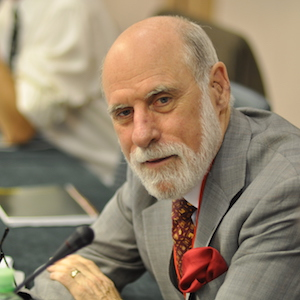

In [9]:
Image(b''.join(http).split(b'\r\n')[12])